In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings

#Uncomment to reduce noise of output
#warnings.filterwarnings("ignore")

<h1> Looking at wine data quality from physicochemical properties</h1>

This note book takes data from this data set https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data and analyses the effect of parameter tuning on a machine learnings ability to predict wine quality from physicochecmical properties.
The notebook is split into sections as per the contents below.

## Contents:
* [Loading and inspecting the data set](#loading-inspecting)
* [Selecting a Model](#model-selection)
* [Hyperparameter tuning](#parameter-tuning)

# Loading and inspecting the data set
<a class="anchor" id="loading-inspecting"></a>

In [76]:
df = pd.read_csv('./wine_quality/winequality-red.csv', sep=';')
#df = pd.read_csv('./wine_quality/winequality-white.csv', sep=';')
#df = pd.read_csv('./data.csv')

## Taking a look at the data 

In [77]:
print("Shape of data:", df.shape)
print(df.info())
df.head()

Shape of data: (1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Performing some basic checks on the data

Checking data quality..
Number of variable null valuess:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Number of duplicate entries: 240
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.90

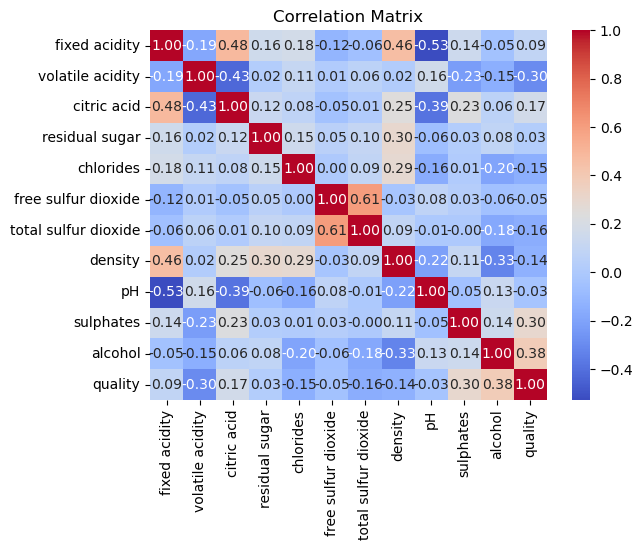

In [78]:
bld = "\033[1m"
end_bld = "\033[0m" 

#Existing quality values in the data
print("Checking data quality..")
print(bld+"Number of variable null valuess:"+end_bld)
print(df.isnull().sum())
print(bld+"\nNumber of duplicate entries:"+end_bld, df.duplicated().sum())

# Calculate basic statistics
statistics = df.describe()
print(statistics)

print("\n\nLooking at the output values... column 'quality'")
unique_classes = df["quality"].unique()
print(bld+"Unique quality values:"+end_bld,unique_classes)
print(bld+"Instance count of quality values:"+end_bld)
print(df["quality"].value_counts())

print("\n\nLooking at the correlations in the data:")
corr_df = df.copy()[[col for col in df.columns if 'Id' not in col]]
corr_df["quality"] = df["quality"].astype('int')
correlation_matrix = corr_df.corr(method='kendall')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Preparing the data for analysis

Data needs to be prepared for analysis and looking at the results from inspection we will need to address the following issues:

* The range of the variables is very different so we might need some normalisation
* Quality is a numerical value so can be made a string class
* Dropping and Id columns where they exist

In [79]:
print(bld+"Preparing the 'data' with:"+end_bld)

print("Replacing the quality variable with a string for easy classification...")
data = df.copy()
data["quality"] = data["quality"].astype(str)

print("Drop the wine Id column if using Kaggle set not raw white and red...")
data = data[[col for col in df.columns if 'Id' not in col]]

print("Scaling the data...")
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]),columns = data.columns[:-1]) #scale the predictors
data_scaled["quality"] = data.quality.copy()

Preparing the 'data' with:
Replacing the quality variable with a string for easy classification...
Drop the wine Id column if using Kaggle set not raw white and red...
Scaling the data...


In [80]:
#Split the data into inputs and outputs
def input_and_outputs(data_in, y_col="quality"):
    return data_in.loc[:, data_in.columns != y_col], data_in.loc[:, y_col]

X_values, y_values = input_and_outputs(data_scaled)

#Split the data into test and training sets
test_size = 0.3
print("Splitting the data in training and test sets with test ratio", test_size, ", and stratifying to ensure class coverage...")
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=test_size, stratify=y_values) 

print("Due to the imbalance in the data set in terms of sample we over sample to try to improve performance on the classifiers")
print("Previous instance class counts full set:\n", y_values.value_counts())
print("Previous instance class counts train:\n", y_train.value_counts())
print("Previous instance class counts test:\n", y_test.value_counts())

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

print("New class instance counts:", y_train_resampled.value_counts())

Splitting the data in training and test sets with test ratio 0.3 , and stratifying to ensure class coverage...
Due to the imbalance in the data set in terms of sample we over sample to try to improve performance on the classifiers
Previous instance class counts full set:
 5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
Previous instance class counts train:
 5    477
6    446
7    139
4     37
8     13
3      7
Name: quality, dtype: int64
Previous instance class counts test:
 5    204
6    192
7     60
4     16
8      5
3      3
Name: quality, dtype: int64
New class instance counts: 5    477
6    477
7    477
4    477
8    477
3    477
Name: quality, dtype: int64


# Testing different models on the data
<a class="anchor" id="model-selection"></a>
In order to select a model I look at a few different options and compare their performance metrics to see which are performing better than the other before trying to tune the parameters.

##### Cluster view: An interesting look at the data to see if it splits into 6 different groups
Using clustering I would like to see if this matches the quality predictions in future

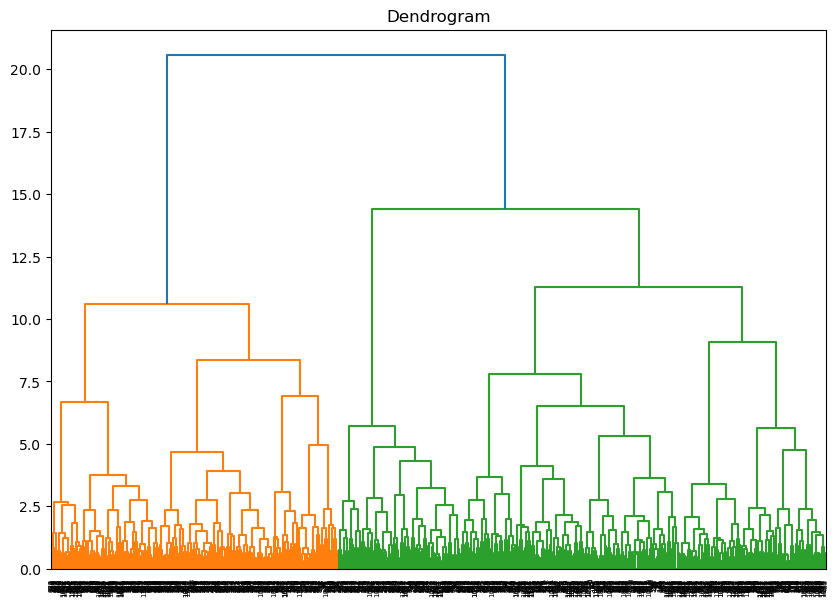

In [37]:
import scipy.cluster.hierarchy as shc

data_scaled = normalize(X_values)
data_scaled = pd.DataFrame(data_scaled, columns=X_values.columns)
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

##### Preparing a set of default classifiers for the problem 

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#Uncomment/comment to alter noise of output
warnings.filterwarnings("ignore")

# Set up multiple models in a dictionary
models = {
    "logistic_regression": LogisticRegression(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "k_nearest_neighbors": KNeighborsClassifier(),
    "support_vector_machine": SVC(),
    "gradient_boosting": GradientBoostingClassifier(),
    "naive_bayes": GaussianNB(),
    "balanced_r_forest": BalancedRandomForestClassifier()
}

logistic_regression
Parameters used int the analysis:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Full classification report:
              precision    recall  f1-score   support

           3       0.05      0.50      0.08         2
           4       0.08      0.30      0.12        10
           5       0.65      0.54      0.59       145
           6       0.58      0.33      0.42       138
           7       0.39      0.53      0.45        43
           8       0.04      0.20      0.07         5

    accuracy                           0.44       343
   macro avg       0.30      0.40      0.29       343
weighted avg       0.56      0.44      0.48       343



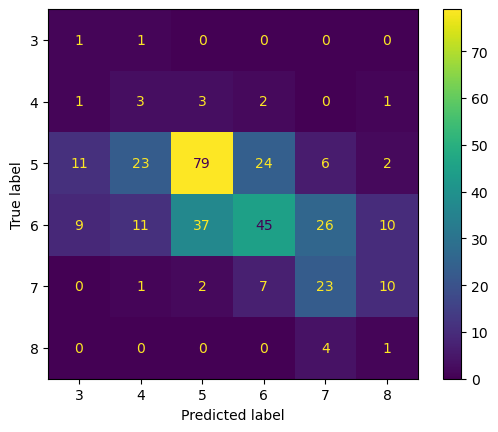

decision_tree
Parameters used int the analysis:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.63      0.65      0.64       145
           6       0.54      0.54      0.54       138
           7       0.42      0.44      0.43        43
           8       0.17      0.20      0.18         5

    accuracy                           0.55       343
   macro avg       0.29      0.30      0.30       343
weighted avg       0.54      0.55      0.54       343



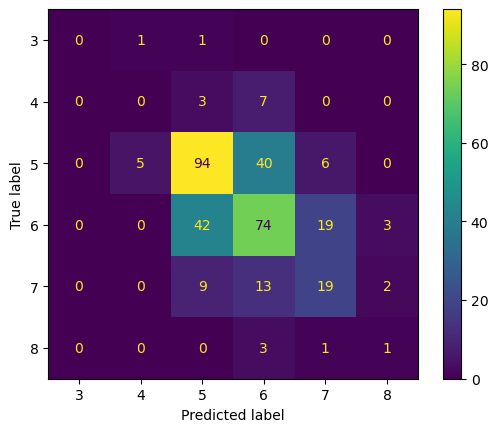

random_forest
Parameters used int the analysis:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.69      0.79      0.74       145
           6       0.62      0.60      0.61       138
           7       0.62      0.56      0.59        43
           8       0.25      0.20      0.22         5

    accuracy                           0.65       343
   macro avg       0.36      0.36      0.36       343
weighted avg       0.62      0.65      0.

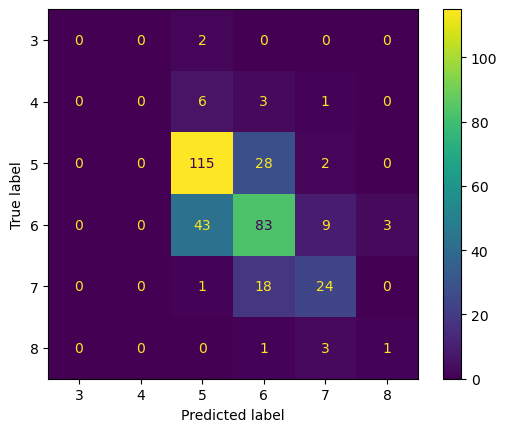

k_nearest_neighbors
Parameters used int the analysis:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.20      0.15        10
           5       0.67      0.63      0.65       145
           6       0.50      0.38      0.43       138
           7       0.35      0.56      0.43        43
           8       0.12      0.20      0.15         5

    accuracy                           0.50       343
   macro avg       0.29      0.33      0.30       343
weighted avg       0.53      0.50      0.51       343



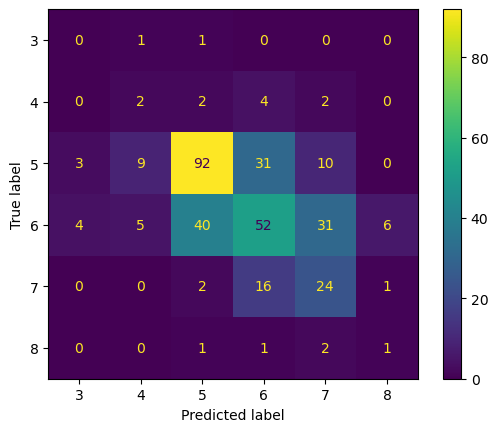

support_vector_machine
Parameters used int the analysis:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.03      0.10      0.05        10
           5       0.64      0.61      0.63       145
           6       0.60      0.47      0.53       138
           7       0.55      0.56      0.55        43
           8       0.06      0.20      0.09         5

    accuracy                           0.52       343
   macro avg       0.31      0.32      0.31       343
weighted avg       0.58      0.52      0.55       343



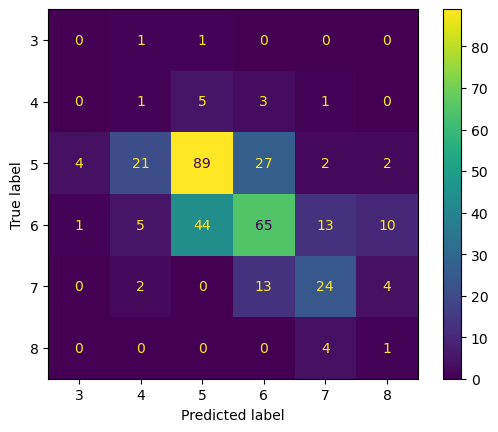

gradient_boosting
Parameters used int the analysis:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.66      0.68      0.67       145
           6       0.59      0.58      0.59       138
           7       0.57      0.58      0.57        43
           8       0.25      0.20      0.22         5

    accuracy                           0.60       343
   macro avg       0.34      0.34      0.34

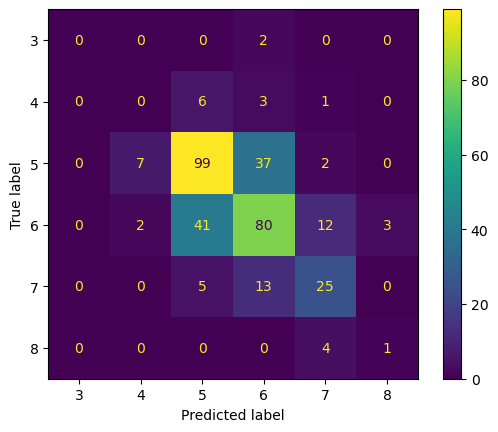

naive_bayes
Parameters used int the analysis:
{'priors': None, 'var_smoothing': 1e-09}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.06      0.20      0.09        10
           5       0.68      0.42      0.52       145
           6       0.57      0.20      0.30       138
           7       0.29      0.37      0.32        43
           8       0.02      0.20      0.04         5

    accuracy                           0.31       343
   macro avg       0.27      0.23      0.21       343
weighted avg       0.55      0.31      0.38       343



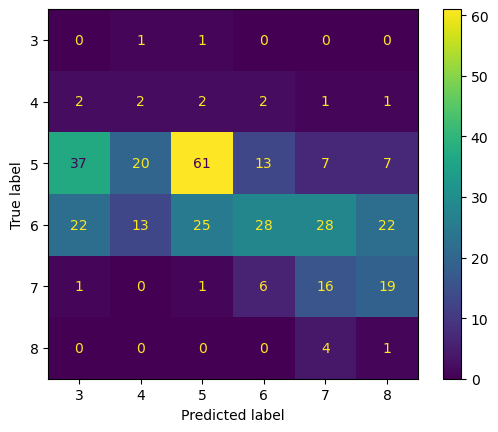

balanced_r_forest
Parameters used int the analysis:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


Full classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.66      0.77      0.71       145
           6       0.59      0.56      0.57       138
           7       0.57      0.53      0.55        43
           8       0.25      0.20      0.22         5

    accuracy                           0.62       343
   macro avg       0.35      0.34      0

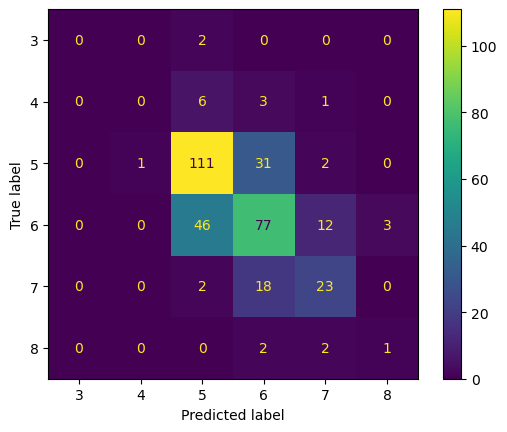

In [39]:
def accuracy_scores(cm):
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    return class_accuracies
    
#AKA true negative rate
def calc_specificity(cm):
    values = []
    for class_index in range(len(cm)):
        true_negatives = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
        false_positives = np.sum(np.delete(cm[class_index, :], class_index))
        if (false_positives + true_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_negatives / (true_negatives + false_positives)
        values.append(specificity)
    return values

def calc_precision(cm):
    precisions = []
    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = np.sum(cm[:, i]) - true_positive
        if (false_positive + true_positive) == 0:
            precision = 0
        else: 
            precision = true_positive / (true_positive + false_positive)
        precisions.append(precision)
    return precisions
    
#AKA recall
def calc_sensitivity(cm):
    values = []
    for class_index in range(len(cm)):
        true_positives = cm[class_index, class_index]
        false_negatives = np.sum(np.delete(cm[class_index, :], class_index))
        if (true_positives + false_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_positives / (true_positives + false_negatives)
        values.append(specificity)
    return values

overall_results = []
raw_results = []

def run():
    for key in models.keys():
        print(key)

        # 1 Fit the classifier model
        current_model = models[key]
        current_model.fit(X_train_resampled, y_train_resampled)

        #2 Prediction  on test set
        predictions = current_model.predict(X_test) 


        #3 Calculate some performance metrics to view and compare
        cm = confusion_matrix(y_test, predictions)

        #Uncomment to filter the classes incase any are missing - unstratified splitting
        #test_classes = [x for x in current_model.classes_ if x in y_test.unique()]
        test_classes = current_model.classes_
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_classes)
        precision_raw = calc_precision(cm)
        recall_raw = calc_sensitivity(cm)
        true_negative_rate_raw = calc_specificity(cm)

        overall_results.append({
            "model": key,
            "accuracy_score": accuracy_score(y_test, predictions),
            "precision": np.mean(precision_raw),
            "recall": np.mean(recall_raw),
            "true_negative_rate": np.mean(true_negative_rate_raw),
        })
        #Uncomment to print as you go 
        #print(pd.DataFrame(overall_results))

        raw_results.append({
            "model": key,
            "accuracy_raw": accuracy_scores(cm),
            "precision_raw": precision_raw,
            "recall_raw": recall_raw,
            "true_negative_rate_raw": true_negative_rate_raw,
            "test_class": test_classes
        })
        #Uncomment to print as you go 
        #print(pd.DataFrame(raw_results))
        
        print("Parameters used int the analysis:")
        print(current_model.get_params())
        print("\n\nFull classification report:")
        print(classification_report(y_test, predictions))
        disp.plot()
        plt.show()
        
run()

In [40]:
overall_results_df = pd.DataFrame(overall_results)
overall_results_df.set_index('model', inplace=True)
overall_results_df = overall_results_df.sort_values(by=["accuracy_score"], ascending=False)
overall_results_df.head(len(models))

,accuracy_score,precision,recall,true_negative_rate
model,,,,
random_forest,0.650146,0.363011,0.358782,0.909726
balanced_r_forest,0.618076,0.346243,0.343062,0.901034
gradient_boosting,0.597668,0.344401,0.340644,0.895633
decision_tree,0.548105,0.293318,0.304395,0.883087
support_vector_machine,0.524781,0.313292,0.323825,0.884061
k_nearest_neighbors,0.498542,0.292857,0.328239,0.878309
logistic_regression,0.443149,0.297282,0.400966,0.873776
naive_bayes,0.314869,0.268413,0.232614,0.858822


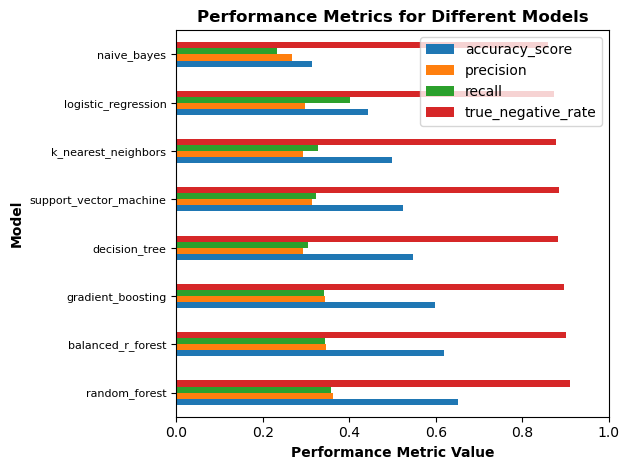

In [42]:
ax = overall_results_df.plot.barh()

plt.yticks(range(len(overall_results_df.index)), overall_results_df.index, fontsize=8)
plt.xlim(0.0, 1.0)

plt.xlabel('Performance Metric Value', fontweight='bold')
plt.ylabel('Model', fontweight='bold')
plt.title('Performance Metrics for Different Models', fontweight='bold')

plt.tight_layout()

In [43]:
results_exploded = [];
results_flattened = [];

for raw_result in raw_results:
    for idx, class_name in enumerate(raw_result["test_class"]):
        results_exploded.append({
            "model": raw_result["model"],
            "class_name": class_name,
            "accuracy": raw_result["accuracy_raw"][idx],
            "precision": raw_result["precision_raw"][idx],
            "recall": raw_result["recall_raw"][idx],
            "true_negative_rate": raw_result["true_negative_rate_raw"][idx],
        })
    
overall_class_results_df = pd.DataFrame(results_exploded)
overall_class_results_df.head(20)
overall_class_results_df = overall_class_results_df.sort_values(by=["accuracy"], ascending=False)

grouped_raw_results = overall_class_results_df.groupby(["class_name", "model"]).agg({
    "accuracy": 'mean',
    "precision": 'mean',
    "recall": 'mean',
    "true_negative_rate": 'mean'
})
grouped_raw_results


accuracy  precision    recall  \
class_name model                                                   
3          balanced_r_forest       0.000000   0.000000  0.000000   
           decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     0.500000   0.045455  0.500000   
           naive_bayes             0.000000   0.000000  0.000000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.000000   0.000000  0.000000   
4          balanced_r_forest       0.000000   0.000000  0.000000   
           decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.200000   0.117647  0.200000   
           logistic_regression     0.300000   0.076923  0.300000   
           naive_bayes             0.200000   0.055556  0.200000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.100000   0.033333  0.100000   
5          balanced_r_forest       0.765517   0.664671  0.765517   
           decision_tree           0.648276   0.630872  0.648276   
           gradient_boosting       0.682759   0.655629  0.682759   
           k_nearest_neighbors     0.634483   0.666667  0.634483   
           logistic_regression     0.544828   0.652893  0.544828   
           naive_bayes             0.420690   0.677778  0.420690   
           random_forest           0.793103   0.688623  0.793103   
           support_vector_machine  0.613793   0.640288  0.613793   
6          balanced_r_forest       0.557971   0.587786  0.557971   
           decision_tree           0.536232   0.540146  0.536232   
           gradient_boosting       0.579710   0.592593  0.579710   
           k_nearest_neighbors     0.376812   0.500000  0.376812   
           logistic_regression     0.326087   0.576923  0.326087   
           naive_bayes             0.202899   0.571429  0.202899   
           random_forest           0.601449   0.624060  0.601449   
           support_vector_machine  0.471014   0.601852  0.471014   
7          balanced_r_forest       0.534884   0.575000  0.534884   
           decision_tree           0.441860   0.422222  0.441860   
           gradient_boosting       0.581395   0.568182  0.581395   
           k_nearest_neighbors     0.558140   0.347826  0.558140   
           logistic_regression     0.534884   0.389831  0.534884   
           naive_bayes             0.372093   0.285714  0.372093   
           random_forest           0.558140   0.615385  0.558140   
           support_vector_machine  0.558140   0.545455  0.558140   
8          balanced_r_forest       0.200000   0.250000  0.200000   
           decision_tree           0.200000   0.166667  0.200000   
           gradient_boosting       0.200000   0.250000  0.200000   
           k_nearest_neighbors     0.200000   0.125000  0.200000   
           logistic_regression     0.200000   0.041667  0.200000   
           naive_bayes             0.200000   0.020000  0.200000   
           random_forest           0.200000   0.250000  0.200000   
           support_vector_machine  0.200000   0.058824  0.200000   

                                   true_negative_rate  
class_name model                                       
3          balanced_r_forest                 0.994169  
           decision_tree                     0.994169  
           gradient_boosting                 0.994169  
           k_nearest_neighbors               0.994048  
           logistic_regression               0.996885  
           naive_bayes                       0.992883  
           random_forest                     0.994169  
           support_vector_machine            0.994083  
4          balanced_r_forest                 0.970760  
           decisio

# Parameter Tuning
<a class="anchor" id="parameter-tuning"></a>

The best model so far has been the RandomForestClassifier so I will focus on this to test hyperparameter tuning.

## Bayes optimisation for hyperparameter search

In [14]:
def plot_performance(search):
    results = search.cv_results_
    plt.figure(figsize=(10, 6))
    plt.plot(results['mean_test_score'], label='Mean Test Score', color='blue')
    plt.fill_between(range(len(results['mean_test_score'])),
                     results['mean_test_score'] - results['std_test_score'],
                     results['mean_test_score'] + results['std_test_score'],
                     alpha=0.3, color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Search Results')
    plt.legend()
    plt.grid(True)
    plt.show()

In [48]:
np.int = int
#Perform hyperparameter tuning with the BayesSearchCV using Bayesian optimization.
def tune_parameters(X, y, model, param_space, n_iter=50, cv=5, random_state=None):
    # Initialize Bayesian optimization
    bayes_opt = BayesSearchCV(model, param_space, n_iter=n_iter, cv=cv, random_state=random_state, n_jobs=-1)
    # Perform parameter tuning
    bayes_opt.fit(X, y)
    
    # Return the best estimator and best hyperparameters: 
    return bayes_opt.best_estimator_, bayes_opt.best_params_, bayes_opt

# Define the search space for hyperparameters
param_space = {
    'n_estimators': Integer(5, 400),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['gini', 'entropy'])
}

# Initialize the classifier model
model = RandomForestClassifier()

# Tune hyperparameters using Bayesian optimization
best_model, best_params, searcher = tune_parameters(X_train_resampled, y_train_resampled, model, param_space, n_iter=50, cv=5, random_state=42)

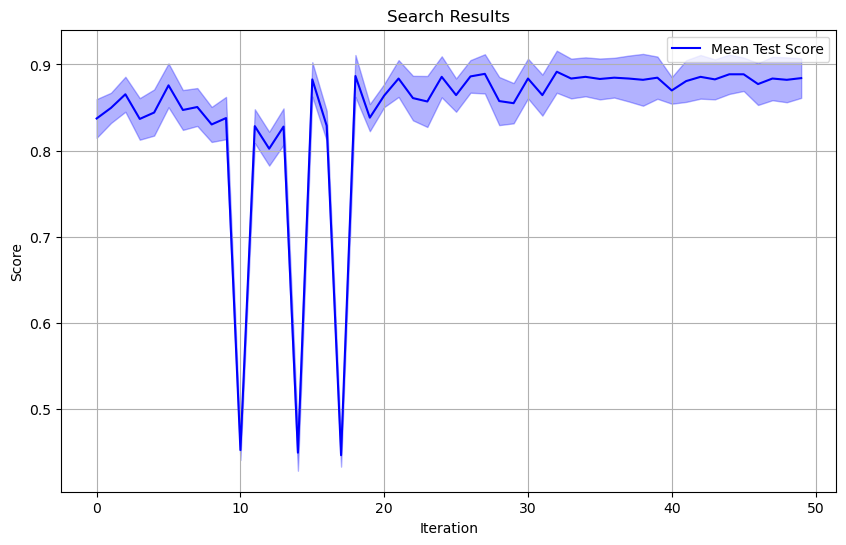

Best Model Params:
 OrderedDict([('criterion', 'gini'), ('max_depth', 46), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])
Model feature importance: [0.06974106 0.11978378 0.07978286 0.05092295 0.07888834 0.07020555
 0.09848777 0.07829468 0.08117359 0.13428136 0.13843805]
Best classifier accuracy: 0.641399416909621


In [49]:
plot_performance(searcher)

print("Best Model Params:\n", best_params)
print("Model feature importance:", best_model.feature_importances_)
# Evaluate the best classifier
score = best_model.score(X_test, y_test)
print("Best classifier accuracy:", score)

## Grid search for hyperparameter search

In [52]:
#Perform hyperparameter tuning using GridSearchCV.
def tune_parameters_with_grid_search(X, y, model, param_grid, cv=5):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    # Perform parameter tuning
    grid_search.fit(X, y)

    # Return the best estimator
    return grid_search.best_estimator_, grid_search.best_params_, grid_search

# Define the search grid for hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize the classifier model
model = RandomForestClassifier()

# Tune hyperparameters using GridSearchCV
best_model, best_params, searcher = tune_parameters_with_grid_search(X_train_resampled, y_train_resampled,model, param_grid, cv=5)

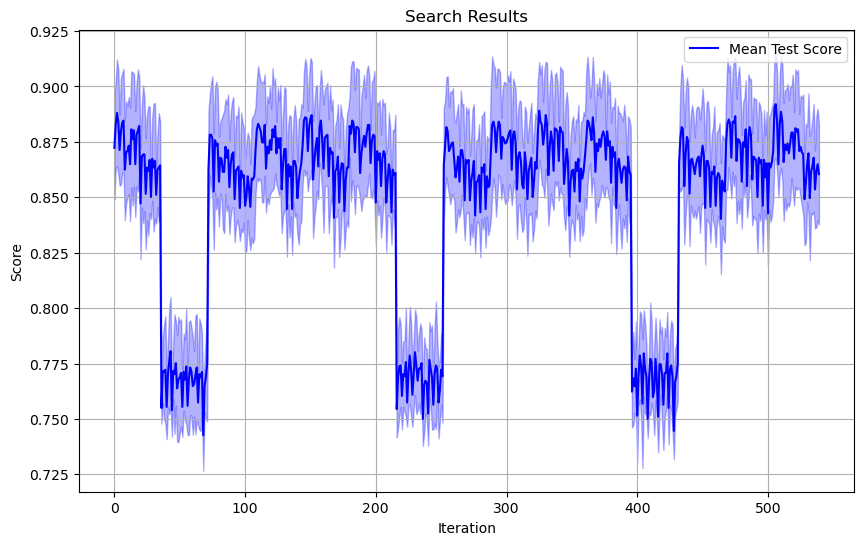

Best Model Params:
 {'class_weight': None, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model feature importance: [0.07242651 0.1181476  0.07499715 0.05461623 0.0775042  0.07136896
 0.09476376 0.07718137 0.08364231 0.13697532 0.1383766 ]
Best classifier accuracy: 0.6443148688046647


In [53]:
plot_performance(searcher)
print("Best Model Params:\n", best_params)
print("Model feature importance:", best_model.feature_importances_)
# Evaluate the best classifier
score = best_model.score(X_test, y_test)
print("Best classifier accuracy:", score)

## Checking the model against the others with parameter search

In [54]:
param_for_models = {
    "logistic_regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],               # Type of regularization
        'solver': ['liblinear', 'saga']        # Solver algorithm
    },
    "decision_tree": {
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "random_forest": {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "k_nearest_neighbors": {
        'n_neighbors': [3, 5, 7, 9],        # Number of neighbors to consider
        'weights': ['uniform', 'distance'],  # Weighting scheme
        'p': [1, 2], 
    },
    "support_vector_machine": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'kernel': ['linear', 'rbf'],      # Kernel function
        'gamma': [0.01, 0.1, 1, 'auto'] ,  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    },
    "gradient_boosting":{
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "naive_bayes": { 
    #No parameters to tune
    },
    "balanced_r_forest": { 
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
}

In [ ]:
tuning_results = []

def run_tuning():
    for key in param_for_models.keys():
        print(key)

        # 1 Fit the classifier model
        current_model = models[key]
        param_grid = param_for_models.get(key)
        
        best_model, best_params, searcher = tune_parameters_with_grid_search(X_train_resampled, y_train_resampled, current_model, param_grid, cv=5)
        score = best_model.score(X_test, y_test)

        tuning_results.append({**{
            "model": key,
            "tuning_type": "grid",
            "best_accuracy_score": score,
        },**best_params}) 
        
run_tuning()

tuning_df = pd.DataFrame(tuning_results)

In [61]:
print("Viewing All the best model results with tuning")
print("Best classifier accuracy:", score)
predictions_best_model = best_model.predict(X_test)
print(classification_report(y_test, predictions_best_model))
print(best_model.get_params())
print("Comparing all the models with tuning")
tuning_df.sort_values(by=["best_accuracy_score"], ascending=False)

Viewing All the best model results with tuning
Best classifier accuracy: 0.6443148688046647
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10
           5       0.69      0.77      0.73       145
           6       0.61      0.61      0.61       138
           7       0.60      0.56      0.58        43
           8       0.50      0.20      0.29         5

    accuracy                           0.64       343
   macro avg       0.40      0.36      0.37       343
weighted avg       0.62      0.64      0.63       343

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose'

,model,tuning_type,best_accuracy_score,C,penalty,solver,max_depth,min_samples_leaf,min_samples_split,n_estimators,n_neighbors,p,weights,gamma,kernel,learning_rate,class_weight
2,random_forest,grid,0.647230,NaN,NaN,NaN,NaN,1.0,5.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,balanced_r_forest,grid,0.641399,NaN,NaN,NaN,30.0,1.0,2.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,balanced
4,support_vector_machine,grid,0.615160,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,rbf,NaN,NaN
5,gradient_boosting,grid,0.609329,NaN,NaN,NaN,5.0,4.0,10.0,100.0,NaN,NaN,NaN,NaN,NaN,0.2,NaN
3,k_nearest_neighbors,grid,0.588921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,distance,NaN,NaN,NaN,NaN
0,logistic_regression,grid,0.454810,10.0,l1,saga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,decision_tree,grid,0.393586,NaN,NaN,NaN,5.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,naive_bayes,grid,0.314869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
print("Comparing this with the previous results:")
overall_results_df.head(len(models))

Comparing this with the previous results:


,accuracy_score,precision,recall,true_negative_rate
model,,,,
random_forest,0.650146,0.363011,0.358782,0.909726
balanced_r_forest,0.618076,0.346243,0.343062,0.901034
gradient_boosting,0.597668,0.344401,0.340644,0.895633
decision_tree,0.548105,0.293318,0.304395,0.883087
support_vector_machine,0.524781,0.313292,0.323825,0.884061
k_nearest_neighbors,0.498542,0.292857,0.328239,0.878309
logistic_regression,0.443149,0.297282,0.400966,0.873776
naive_bayes,0.314869,0.268413,0.232614,0.858822


Overall it looks like better results were acheived without tuning here so the original modal would be used

In [81]:
predicts = models['random_forest'].predict(X_test)
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       1.00      0.25      0.40        16
           5       0.82      0.89      0.85       204
           6       0.79      0.79      0.79       192
           7       0.76      0.75      0.76        60
           8       0.67      0.40      0.50         5

    accuracy                           0.80       480
   macro avg       0.67      0.51      0.55       480
weighted avg       0.80      0.80      0.79       480



In [82]:
predicts = best_model.predict(X_test)
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.67      0.25      0.36        16
           5       0.80      0.89      0.84       204
           6       0.80      0.76      0.78       192
           7       0.75      0.78      0.76        60
           8       0.67      0.40      0.50         5

    accuracy                           0.79       480
   macro avg       0.61      0.51      0.54       480
weighted avg       0.78      0.79      0.78       480

